In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import warnings
warnings.filterwarnings("ignore")

# Display all columns
pd.set_option('display.max_columns', None)

In [2]:
# Load the stage 2 property data
df = pd.read_csv(r'Output Files\stage_2_property_data.csv') 
df.head(3)

,Possession Status,Availability Starts From,Floor No,Commercial,Developer,Price (Crores),Landmark,Covered Area,Society,sqft Price (INR),Carpet Area,Area,Unit of Carpet Area,Furnished Type,Bathrooms,Facing,Transaction Type,Type of Property,City,Bedrooms,Posted By,Total Floors,isPrimeLocationProperty,Unit of Covered Area,Property Lifespan,Balconies,Power Back Up,Lift,Rain Water Harvesting,Club House,Swimming Pool,Gymnasium,Park,Parking,Security,Water Storage,Private Terrace/Garden,Vaastu Compliant,Service/Goods Lift,Air Conditioned,Visitor Parking,Intercom Facility,Maintenance Staff,Waste Disposal,Laundry Service,Internet/Wi-Fi Connectivity,DTH Television Facility,RO Water System,Banquet Hall,Bar/Lounge,Cafeteria/Food Court,Conference Room,Piped Gas,Jogging and Strolling Track,Outdoor Tennis Courts,Mansion,Downtown,Skyline View,Wrap Around Balcony,Island Kitchen Layout,Full Glass Wall,House help accommodation,Concierge Services,Garden View,Marble flooring,Well Furnished,Modular Kitchen,Helipad,Private pool,Private Jaccuzi,Mini Cinema Theatre,Golf Course,Infinity Swimming Pool,Pool with temperature control,Sea facing,Skydeck,Earth quake resistant,Theme based Architectures,Health club with Steam / Jaccuzi,Large Clubhouse,Large Open space,Fingerprint Access,Grand Entrance lobby,Private Garage,Fireplace,Wine Cellar,Sky Villa,Water Front,Hilltop,Smart Home,Barbeque space,Kids play area,Library,Puja Room,Study,Servant Room,Store,Aerobics Room,Canopy Walk,Coffee Lounge & Restaurants,Dance Studio,Event Space & Amphitheatre,Flower Gardens,Guest Accommodation,Indoor Squash & Badminton Courts,Kids Play Area,Kids Play Pool With Water Slides,Library And Business Centre,Meditation Area,Multipurpose Courts,Recreational Pool,Rentable CommuniPfty Space,Retail Boulevard (Retail Shops),Cycling & Jogging Track,Fire Fighting Equipment,Aesthetically designed landscape garden,latitude,longitude,geocoded_address,Area_Broader
0,Ready to Move,Immediately,20.0,Y,Tata Housing Development Company Ltd.,0.63,Rajoli naka,579.0,Tata Amantra,10880.0,579.0,Kalyan West,Sq-ft,Unfurnished,2.0,East,New Property,Apartment,Thane,2,Agent,34.0,Y,Sq-ft,New construction,NaN,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,19.240353,73.125279,"Kalyan West, Kalyan-Dombivli, Kalyan Taluka, T...",Kalyan West
1,Ready to Move,Immediately,18.0,N,Sai Satyam Developers,0.54,This property has reputed scholl ints vicinity.,850.0,Sai Satyam Homes,6352.0,585.0,Kalyan West,Sq-ft,Unfurnished,2.0,East,New Property,Apartment,Thane,2,Agent,18.0,Y,Sq-ft,New construction,NaN,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,19.240353,73.125279,"Kalyan West, Kalyan-Dombivli, Kalyan Taluka, T...",Kalyan West
2,Under Construction,Dec 25,5.0,N,Birla Estates,0.90,Shahad is one of the attractive locations to o...,1050.0,Birla Vanya,8571.0,815.0,Kalyan West,Sq-ft,Unfurnished,2.0,East,New Property,Apartment,Thane,2,Agent,27.0,Y,Sq-ft,NaN,3.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,19.240353,73.125279,"Kalyan West, Kalyan-Dombivli, Kalyan Taluka, T...",Kalyan West


In [3]:
# Shape
df.shape

(6305, 120)

# <b>Outlier Detection and Treatment</b>

#### Utilities

In [4]:
# Function to plot Distribution plot and Box plot for a dataframe column
def plot_distribution_and_boxplot(df: pd.DataFrame, column: str):
    """
    Plot histogram with KDE and boxplot for a given column in a DataFrame.

    Args:
        df (pd.DataFrame): Input DataFrame
        column (str): Column name to plot
    """
    sns.set_style('whitegrid')
    palette = sns.color_palette('pastel')

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Distribution plot on the left
    sns.histplot(df[column].dropna(), kde=True, color=palette[0], ax=axes[0], edgecolor='black', linewidth=0.7)

    axes[0].set_title(f'Distribution of {column}', fontsize=16, fontweight='bold')
    axes[0].set_xlabel(column, fontsize=14)
    axes[0].set_ylabel('Density', fontsize=14)

    # Box plot on the right
    sns.boxplot(x=df[column], color=palette[1], ax=axes[1], fliersize=5, linewidth=1.2)
    axes[1].set_title(f'Boxplot of {column}', fontsize=16, fontweight='bold')
    axes[1].set_xlabel(column, fontsize=14)
    axes[1].set_yticks([])  # Hide y-axis ticks for boxplot

    plt.tight_layout()
    plt.show()

----------------

####  Price (Crores)

In [5]:
# Statistics
df['Price (Crores)'].describe()

count    6258.000000
mean        3.183100
std        51.649733
min         0.010000
25%         0.770000
50%         1.500000
75%         2.800000
max      4080.000000
Name: Price (Crores), dtype: float64

##### Observations:
1- The majority of price lies between ~0.77 Crores and 3 Crores. \
2- Mean > Median -> Right skewed distribution. \
3- The standard deviation (51.64) is extremely large compared to the IQR (2.8 - 0.77 = 2.03) i.e. the spread of typical property prices, indicating high strong skewness and extreme outliers. \
4- The maximum value (4080 crores) is extraordinarily high and clearly not typical. \
5- We can consider:
- Using Median instead of Mean.
- Applying log-transformation to reduce skewness.
- Removing or caping outliers.
- Separating normal listings (say < ₹10 Cr) from luxury ones.

In [6]:
# Drop property having 4080 Crores price: Data Entry error

# Get Index
idx = df[df['Price (Crores)'] == df['Price (Crores)'].max()].index

# Drop permanently
df.drop(index=idx, inplace=True)

In [7]:
# Updated stats
df['Price (Crores)'].describe()

count    6257.000000
mean        2.531539
std         3.313215
min         0.010000
25%         0.770000
50%         1.500000
75%         2.800000
max        45.000000
Name: Price (Crores), dtype: float64

In [8]:
# Detect outliers in 'Price (Crores)' using IQR method
Q1 = df['Price (Crores)'].quantile(0.25)
Q3 = df['Price (Crores)'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers_price_df = df[(df['Price (Crores)'] < lower_bound) | (df['Price (Crores)'] > upper_bound)]

print('Lower bound: ', max(lower_bound, df['Price (Crores)'].min()))
print('Upper bound: ', min(upper_bound, df['Price (Crores)'].max()))
print('Number of Outliers in Price: ', outliers_price_df.shape[0])
print()

# Outliers stats
print('--------Statistics of Outliers in Prices---------')
outliers_price_df['Price (Crores)'].describe()

Lower bound:  0.01
Upper bound:  5.845
Number of Outliers in Price:  666

--------Statistics of Outliers in Prices---------


count    666.000000
mean       9.997863
std        5.304815
min        5.850000
25%        6.912500
50%        8.500000
75%       11.000000
max       45.000000
Name: Price (Crores), dtype: float64

##### Observations:
1- The distribution of outliers still shows concentration.
- The median outlier price is ₹8.5 Cr, with 75% of the outliers falling below ₹11 Cr.
- That means even among outliers, most are within a narrow high range, suggesting a cluster of premium properties rather than pure noise.

2- Spread within outliers is moderate. Standard deviation of 5.3 Cr is moderate relative to the mean (9.99 Cr), so even within outliers, the spread is not wild. \
3- These values should not be removed blindly, many of them could be genuine high-end listings rather than data errors.


In [9]:
# Filter out price outlier properties and save to excel file for manual analysis
outliers_price_df.to_excel('Output Files\\outliers_price.xlsx')


Analysis in Excel reveals these are genuine entries but following properties were having data error.

In [9]:
# Inaccurate entries
df.loc[[1510, 5505, 5931, 1662, 3789]]

,Possession Status,Availability Starts From,Floor No,Commercial,Developer,Price (Crores),Landmark,Covered Area,Society,sqft Price (INR),Carpet Area,Area,Unit of Carpet Area,Furnished Type,Bathrooms,Facing,Transaction Type,Type of Property,City,Bedrooms,Posted By,Total Floors,isPrimeLocationProperty,Unit of Covered Area,Property Lifespan,Balconies,Power Back Up,Lift,Rain Water Harvesting,Club House,Swimming Pool,Gymnasium,Park,Parking,Security,Water Storage,Private Terrace/Garden,Vaastu Compliant,Service/Goods Lift,Air Conditioned,Visitor Parking,Intercom Facility,Maintenance Staff,Waste Disposal,Laundry Service,Internet/Wi-Fi Connectivity,DTH Television Facility,RO Water System,Banquet Hall,Bar/Lounge,Cafeteria/Food Court,Conference Room,Piped Gas,Jogging and Strolling Track,Outdoor Tennis Courts,Mansion,Downtown,Skyline View,Wrap Around Balcony,Island Kitchen Layout,Full Glass Wall,House help accommodation,Concierge Services,Garden View,Marble flooring,Well Furnished,Modular Kitchen,Helipad,Private pool,Private Jaccuzi,Mini Cinema Theatre,Golf Course,Infinity Swimming Pool,Pool with temperature control,Sea facing,Skydeck,Earth quake resistant,Theme based Architectures,Health club with Steam / Jaccuzi,Large Clubhouse,Large Open space,Fingerprint Access,Grand Entrance lobby,Private Garage,Fireplace,Wine Cellar,Sky Villa,Water Front,Hilltop,Smart Home,Barbeque space,Kids play area,Library,Puja Room,Study,Servant Room,Store,Aerobics Room,Canopy Walk,Coffee Lounge & Restaurants,Dance Studio,Event Space & Amphitheatre,Flower Gardens,Guest Accommodation,Indoor Squash & Badminton Courts,Kids Play Area,Kids Play Pool With Water Slides,Library And Business Centre,Meditation Area,Multipurpose Courts,Recreational Pool,Rentable CommuniPfty Space,Retail Boulevard (Retail Shops),Cycling & Jogging Track,Fire Fighting Equipment,Aesthetically designed landscape garden,latitude,longitude,geocoded_address,Area_Broader
1510,Ready to Move,Immediately,7.0,N,Ev Group,37.0,NaN,570.0,Evan Elegance,649123.0,NaN,Vasai West,Sq-ft,Semi-Furnished,1.0,NaN,Resale,Residential House,Mumbai,1,Owner,7.0,Y,Sq-ft,Less than 5 years,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19.054999,72.869203,"Mumbai Suburban, Maharashtra, India",Vasai West
5505,Ready to Move,Immediately,5.0,N,Neumec Group,20.0,NaN,1344.0,Amboli Angles,148810.0,NaN,Andheri West,Sq-ft,Furnished,2.0,NaN,Resale,Apartment,Mumbai,2,Owner,6.0,N,Sq-ft,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19.117249,72.833968,"Andheri West, K/W Ward, Zone 3, Mumbai Suburba...",Andheri West
5931,Ready to Move,Immediately,4.0,N,Sankalp Developers,23.5,NaN,700.0,Sankalp Apartment,335714.0,650.0,Andheri East,Sq-ft,Furnished,2.0,East,Resale,Apartment,Mumbai,2,Owner,7.0,Y,Sq-ft,15 to 20 years,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19.115883,72.854202,"Andheri East, K/E Ward, Zone 3, Mumbai Suburba...",Andheri East
1662,Ready to Move,Immediately,5.0,N,Lodha,19.0,NaN,902.0,Lodha Sterling,210643.0,NaN,Thane West,Sq-ft,Unfurnished,2.0,NaN,Resale,Apartment,Thane,2,Owner,7.0,Y,Sq-ft,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19.233861,72.986409,"Lodha Sterling Clubhouse, Akbar Camp Road, Kol...",Thane West
3789,"Not Available, Contact Developer","Not Available, Contact Developer",26.0,N,Oberoi Realty Ltd.,8.0,NaN,NaN,Oberoi Esquire,NaN,NaN,Goregaon East,NaN,Furnished,3.0,NaN,Resale,Apartment,Mumbai,2,Owner,50.0,Y,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [10]:
# Drop these permanently
df.drop(index=[1510, 5505, 5931, 1662, 3789], inplace=True)

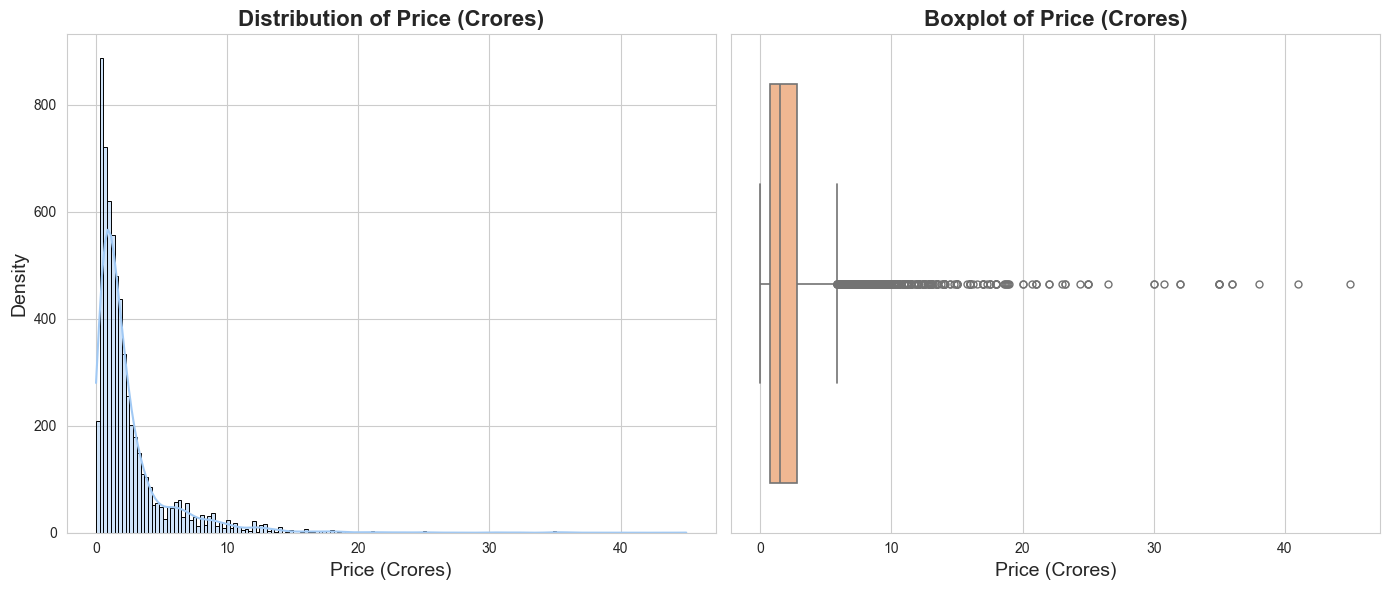

In [11]:
# Plot distribution and Box plot for price
plot_distribution_and_boxplot(df, 'Price (Crores)')

Price (Crores) column is right skewed and there are extreme Prices over 25 Crores.

In [12]:
# Capping the extreme prices to 25 Crores
df_sub = df[df['Price (Crores)'] > 25]
df_sub['Price (Crores)'] = 25

In [13]:
# Update original df
df.update(df_sub)

-------------

#### Floor No

In [14]:
# Stats
df['Floor No'].describe()

count    5899.000000
mean       10.638074
std         9.522103
min        -2.000000
25%         4.000000
50%         8.000000
75%        15.000000
max        93.000000
Name: Floor No, dtype: float64

In [15]:
# Detect outliers in 'Floor No' using IQR method
Q1 = df['Floor No'].quantile(0.25)
Q3 = df['Floor No'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers_Floor_No_df = df[(df['Floor No'] < lower_bound) | (df['Floor No'] > upper_bound)]

print('Lower bound: ', max(lower_bound, df['Floor No'].min()))
print('Upper bound: ', min(upper_bound, df['Floor No'].max()))
print('Number of Outliers in Floor No: ', outliers_Floor_No_df.shape[0])
print()

# Outliers stats
print('--------Statistics of Outliers in Floor No---------')
outliers_Floor_No_df['Floor No'].describe()

Lower bound:  -2.0
Upper bound:  31.5
Number of Outliers in Floor No:  242

--------Statistics of Outliers in Floor No---------


count    242.000000
mean      41.123967
std        9.157515
min       32.000000
25%       35.000000
50%       38.500000
75%       45.000000
max       93.000000
Name: Floor No, dtype: float64

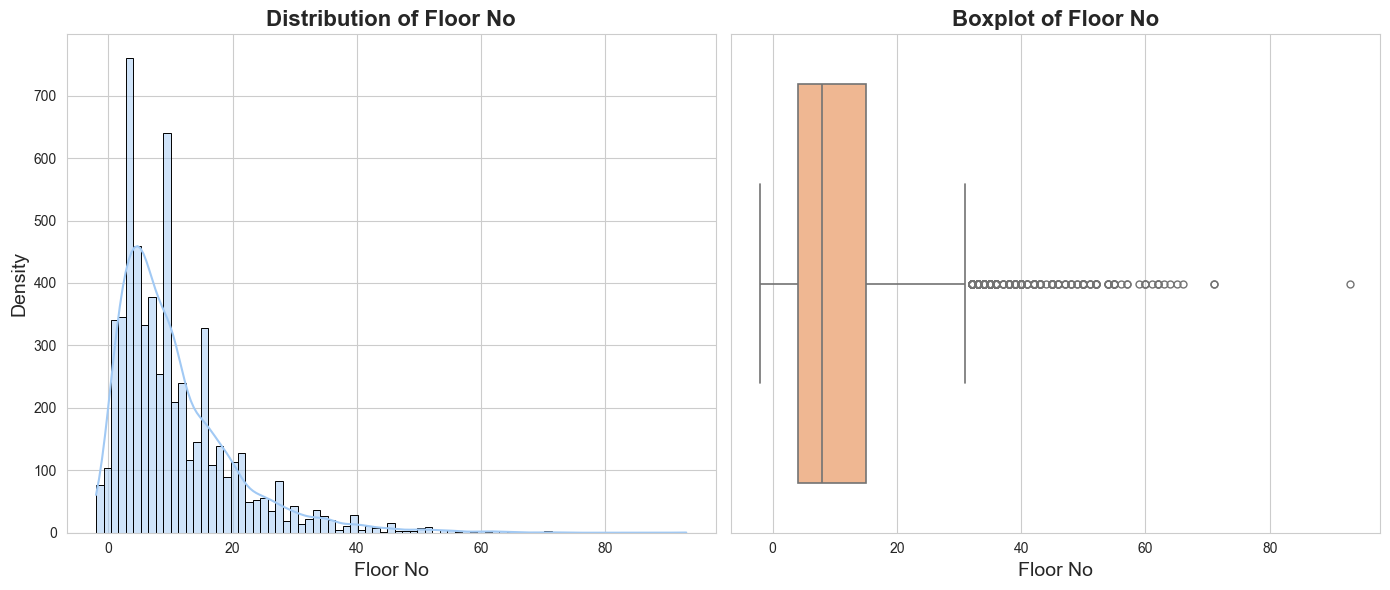

In [16]:
plot_distribution_and_boxplot(df, 'Floor No')

These are genuine entries and not data error.

-----------------

#### Covered Area

In [17]:
# Stats
df['Covered Area'].describe()

count     5645.000000
mean      1101.578044
std        792.100644
min        170.000000
25%        646.000000
50%        900.000000
75%       1250.000000
max      20870.000000
Name: Covered Area, dtype: float64

##### Observations:
1- The majority of 'Covered Area' data is concentrated between ~600 sqft and 1300 sqft. \
2- The mean is inflated due to a few large values (outliers). Mean > Median -> Right-skewed distribution. \
3- There are extreme high-end properties or errors which should should be inspected. \
4- We can consider:
- Using Median instead of Mean.
- Applying log-transformation to reduce skewness.
- Removing or caping outliers.

In [18]:
# Detect outliers in 'Covered Area' using IQR method
Q1 = df['Covered Area'].quantile(0.25)
Q3 = df['Covered Area'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers_Covered_Area_df = df[(df['Covered Area'] < lower_bound) | (df['Covered Area'] > upper_bound)]

print('Lower bound: ', max(lower_bound, df['Covered Area'].min()))
print('Upper bound: ', min(upper_bound, df['Covered Area'].max()))
print('Number of Outliers in Covered Area: ', outliers_Covered_Area_df.shape[0])
print()

# Outliers stats
print('--------Statistics of Outliers in Covered Area---------')
outliers_Covered_Area_df['Covered Area'].describe()

Lower bound:  170.0
Upper bound:  2156.0
Number of Outliers in Covered Area:  426

--------Statistics of Outliers in Covered Area---------


count      426.000000
mean      3139.906103
std       1365.414363
min       2171.000000
25%       2403.750000
50%       2800.000000
75%       3307.500000
max      20870.000000
Name: Covered Area, dtype: float64

In [19]:
# Filter out Covered area outlier properties and save to excel file for manual analysis
outliers_Covered_Area_df.to_excel('Output Files\\outliers_Covered_Area.xlsx')

Analysis in excel reveals that these are genuine entries apart from few properties having data errors. 

In [20]:
# Properties having data error in 'Covered Area'
df.loc[[1337, 5540, 1690, 3737]]

,Possession Status,Availability Starts From,Floor No,Commercial,Developer,Price (Crores),Landmark,Covered Area,Society,sqft Price (INR),Carpet Area,Area,Unit of Carpet Area,Furnished Type,Bathrooms,Facing,Transaction Type,Type of Property,City,Bedrooms,Posted By,Total Floors,isPrimeLocationProperty,Unit of Covered Area,Property Lifespan,Balconies,Power Back Up,Lift,Rain Water Harvesting,Club House,Swimming Pool,Gymnasium,Park,Parking,Security,Water Storage,Private Terrace/Garden,Vaastu Compliant,Service/Goods Lift,Air Conditioned,Visitor Parking,Intercom Facility,Maintenance Staff,Waste Disposal,Laundry Service,Internet/Wi-Fi Connectivity,DTH Television Facility,RO Water System,Banquet Hall,Bar/Lounge,Cafeteria/Food Court,Conference Room,Piped Gas,Jogging and Strolling Track,Outdoor Tennis Courts,Mansion,Downtown,Skyline View,Wrap Around Balcony,Island Kitchen Layout,Full Glass Wall,House help accommodation,Concierge Services,Garden View,Marble flooring,Well Furnished,Modular Kitchen,Helipad,Private pool,Private Jaccuzi,Mini Cinema Theatre,Golf Course,Infinity Swimming Pool,Pool with temperature control,Sea facing,Skydeck,Earth quake resistant,Theme based Architectures,Health club with Steam / Jaccuzi,Large Clubhouse,Large Open space,Fingerprint Access,Grand Entrance lobby,Private Garage,Fireplace,Wine Cellar,Sky Villa,Water Front,Hilltop,Smart Home,Barbeque space,Kids play area,Library,Puja Room,Study,Servant Room,Store,Aerobics Room,Canopy Walk,Coffee Lounge & Restaurants,Dance Studio,Event Space & Amphitheatre,Flower Gardens,Guest Accommodation,Indoor Squash & Badminton Courts,Kids Play Area,Kids Play Pool With Water Slides,Library And Business Centre,Meditation Area,Multipurpose Courts,Recreational Pool,Rentable CommuniPfty Space,Retail Boulevard (Retail Shops),Cycling & Jogging Track,Fire Fighting Equipment,Aesthetically designed landscape garden,latitude,longitude,geocoded_address,Area_Broader
1337,"Not Available, Contact Developer","Not Available, Contact Developer",2.0,Y,Gm Developers,0.01,NaN,6000.0,Dadar Yashodhan,17.0,6000.0,Dadar West,Sq-ft,Unfurnished,1.0,NaN,Resale,Apartment,Mumbai,2,Owner,7.0,N,Sq-ft,NaN,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19.020782,72.841930,"Thyrocare Aarogyam Center - Dadar West, N C Ke...",Dadar West
5540,Ready to Move,Immediately,5.0,Y,Interintel Constructions,2.55,Ceasar road amboli near church,7125.0,Gurnani Palms,23181.0,1100.0,Andheri West,Sq-ft,Semi-Furnished,2.0,NaN,Resale,Apartment,Mumbai,2,Agent,16.0,Y,Sq-ft,New construction,NaN,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,19.128559,72.842647,"Gurnani Palms, Jai Bhawani Mata Road, Azad Nag...",Andheri West
1690,Ready to Move,Immediately,22.0,Y,Pridedream Realtors,2.00,Near malhar talkies,10892.0,Giriraj Dreams,1836.0,746.0,Naupada,Sq-ft,Unfurnished,2.0,North,New Property,Apartment,Thane,2,Agent,30.0,Y,Sq-ft,NaN,3.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,19.189685,72.969684,"Naupada, Thane, Thane Taluka, Thane, Maharasht...",Thane West
3737,Ready to Move,Immediately,NaN,N,Oberoi Realty Ltd.,12.00,Western expressway highway (5 min) | juhu airp...,20870.0,Oberoi Esquire,31872.0,3765.0,Goregaon East,Sq-ft,Unfurnished,5.0,North,Resale,Apartment,Mumbai,4,Agent,NaN,Y,Sq-ft,Less than 5 years,NaN,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,19.169262,72.855255,"Goregaon East, P/S Ward, Zone 4, Mumbai Suburb...",Goregaon East


In [21]:
# Drop index 1337
df.drop(index=1337, inplace=True)

# Fix Covered area of index 5540
df.loc[5540, 'Covered Area'] = df.loc[5540, 'Carpet Area'] * (df['Covered Area'].median()/df['Carpet Area'].median())

# Fix Covered area of index 1690
df.loc[1690, 'Covered Area'] = df.loc[1690, 'Carpet Area'] * (df['Covered Area'].median()/df['Carpet Area'].median())

# Fix Covered area of index 3737
df.loc[3737, 'Covered Area'] = df.loc[3737, 'Carpet Area'] * (df['Covered Area'].median()/df['Carpet Area'].median())

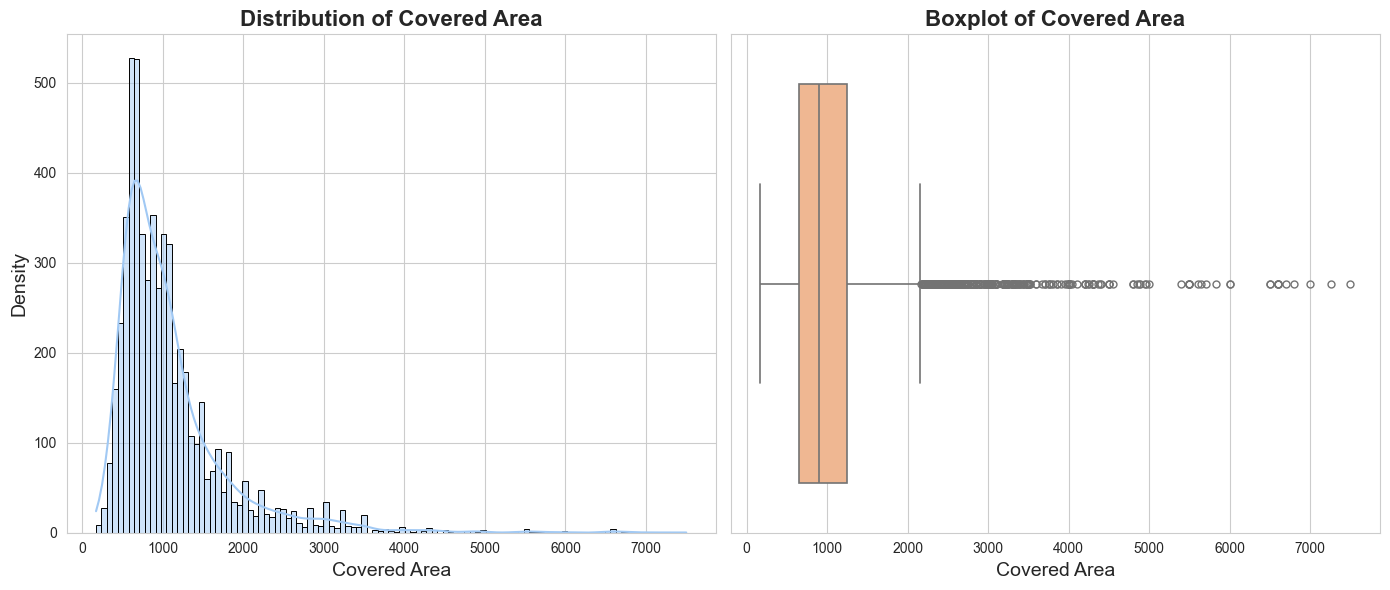

In [22]:
plot_distribution_and_boxplot(df, 'Covered Area')

-----------------

#### Carpet Area

In [23]:
# Stats
df['Carpet Area'].describe()

count    5181.000000
mean      844.815287
std       570.425915
min        33.000000
25%       475.000000
50%       684.000000
75%       987.000000
max      6436.000000
Name: Carpet Area, dtype: float64

##### Observations:
1- Majority of the Carpet area lies between 450 sqft and 1000 sqft. \
2- Mean > Median -> Right skewed distribution. \
3- Wide variation: A standard deviation of 570 sq ft is quite high, reflecting significant variability in property sizes.\
4- We can consider:
- Using Median instead of Mean.
- Applying log transformation to reduce the skewness.



In [24]:
# Detect outliers in 'Covered Area' using IQR method
Q1 = df['Carpet Area'].quantile(0.25)
Q3 = df['Carpet Area'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers_Carpet_Area_df = df[(df['Carpet Area'] < lower_bound) | (df['Carpet Area'] > upper_bound)]

print('Lower bound: ', max(lower_bound, df['Carpet Area'].min()))
print('Upper bound: ', min(upper_bound, df['Carpet Area'].max()))
print('Number of Outliers in Carpet Area: ', outliers_Carpet_Area_df.shape[0])
print()

# Outliers stats
print('--------Statistics of Outliers in Carpet Area---------')
outliers_Carpet_Area_df['Carpet Area'].describe()

Lower bound:  33.0
Upper bound:  1755.0
Number of Outliers in Carpet Area:  380

--------Statistics of Outliers in Carpet Area---------


count     380.000000
mean     2402.486842
std       737.512697
min      1760.000000
25%      1980.000000
50%      2101.000000
75%      2500.000000
max      6436.000000
Name: Carpet Area, dtype: float64

In [25]:
# Filter out Carpet area outlier properties and save to excel file for manual analysis
outliers_Carpet_Area_df.to_excel('Output Files\\outliers_Carpet_Area.xlsx')

Analysis in Excel reveals that these outliers are genuine properties apart from the following having data entry error.

In [26]:
# Data entry error
df.loc[[5071]]

,Possession Status,Availability Starts From,Floor No,Commercial,Developer,Price (Crores),Landmark,Covered Area,Society,sqft Price (INR),Carpet Area,Area,Unit of Carpet Area,Furnished Type,Bathrooms,Facing,Transaction Type,Type of Property,City,Bedrooms,Posted By,Total Floors,isPrimeLocationProperty,Unit of Covered Area,Property Lifespan,Balconies,Power Back Up,Lift,Rain Water Harvesting,Club House,Swimming Pool,Gymnasium,Park,Parking,Security,Water Storage,Private Terrace/Garden,Vaastu Compliant,Service/Goods Lift,Air Conditioned,Visitor Parking,Intercom Facility,Maintenance Staff,Waste Disposal,Laundry Service,Internet/Wi-Fi Connectivity,DTH Television Facility,RO Water System,Banquet Hall,Bar/Lounge,Cafeteria/Food Court,Conference Room,Piped Gas,Jogging and Strolling Track,Outdoor Tennis Courts,Mansion,Downtown,Skyline View,Wrap Around Balcony,Island Kitchen Layout,Full Glass Wall,House help accommodation,Concierge Services,Garden View,Marble flooring,Well Furnished,Modular Kitchen,Helipad,Private pool,Private Jaccuzi,Mini Cinema Theatre,Golf Course,Infinity Swimming Pool,Pool with temperature control,Sea facing,Skydeck,Earth quake resistant,Theme based Architectures,Health club with Steam / Jaccuzi,Large Clubhouse,Large Open space,Fingerprint Access,Grand Entrance lobby,Private Garage,Fireplace,Wine Cellar,Sky Villa,Water Front,Hilltop,Smart Home,Barbeque space,Kids play area,Library,Puja Room,Study,Servant Room,Store,Aerobics Room,Canopy Walk,Coffee Lounge & Restaurants,Dance Studio,Event Space & Amphitheatre,Flower Gardens,Guest Accommodation,Indoor Squash & Badminton Courts,Kids Play Area,Kids Play Pool With Water Slides,Library And Business Centre,Meditation Area,Multipurpose Courts,Recreational Pool,Rentable CommuniPfty Space,Retail Boulevard (Retail Shops),Cycling & Jogging Track,Fire Fighting Equipment,Aesthetically designed landscape garden,latitude,longitude,geocoded_address,Area_Broader
5071,Ready to Move,Immediately,9.0,Y,Godrej Properties,1.95,NaN,NaN,Godrej Tranquil,NaN,6436.0,Kandivali East,NaN,Unfurnished,2.0,NaN,Resale,Apartment,Mumbai,2,Owner,22.0,N,NaN,New construction,NaN,1,1,1,1,1,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19.198314,72.860647,"Akurli, Western Express Highway, Kandivali Eas...",Kandivali East


In [27]:
# Drop permanently
df.drop(index=5071, inplace=True)

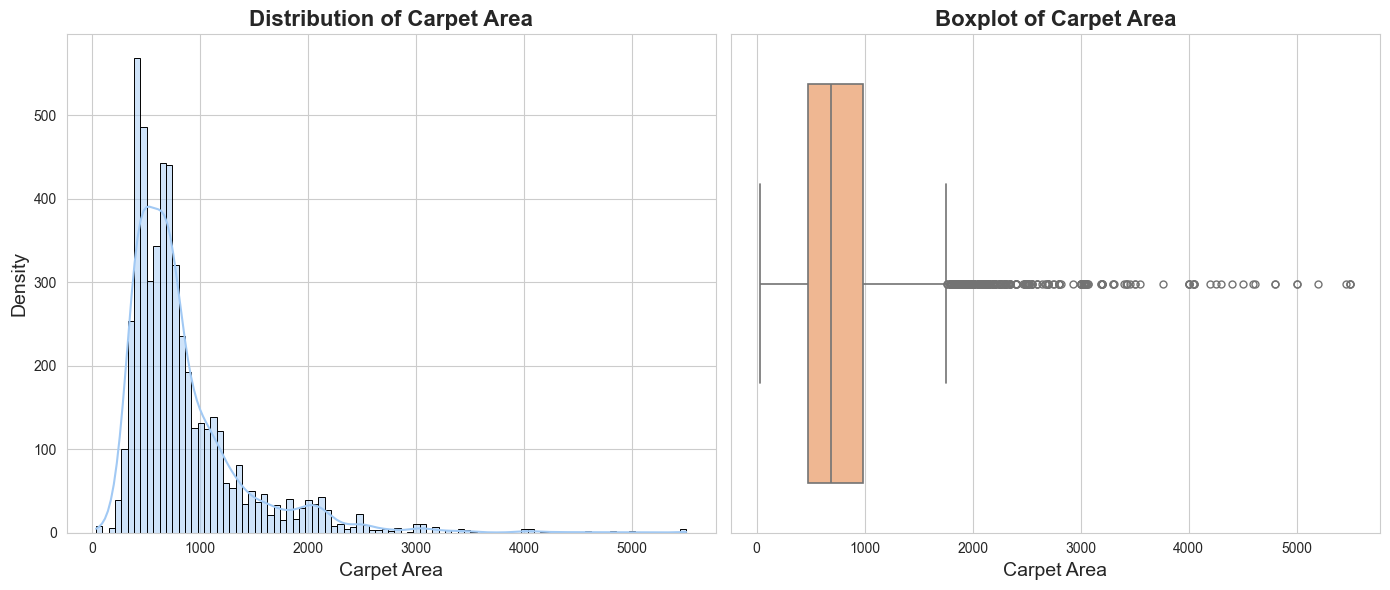

In [28]:
plot_distribution_and_boxplot(df, 'Carpet Area')

In [29]:
# Properties having Carpet area less than 150 sqft
df[df['Carpet Area'] < 150].sort_values('Carpet Area')

,Possession Status,Availability Starts From,Floor No,Commercial,Developer,Price (Crores),Landmark,Covered Area,Society,sqft Price (INR),Carpet Area,Area,Unit of Carpet Area,Furnished Type,Bathrooms,Facing,Transaction Type,Type of Property,City,Bedrooms,Posted By,Total Floors,isPrimeLocationProperty,Unit of Covered Area,Property Lifespan,Balconies,Power Back Up,Lift,Rain Water Harvesting,Club House,Swimming Pool,Gymnasium,Park,Parking,Security,Water Storage,Private Terrace/Garden,Vaastu Compliant,Service/Goods Lift,Air Conditioned,Visitor Parking,Intercom Facility,Maintenance Staff,Waste Disposal,Laundry Service,Internet/Wi-Fi Connectivity,DTH Television Facility,RO Water System,Banquet Hall,Bar/Lounge,Cafeteria/Food Court,Conference Room,Piped Gas,Jogging and Strolling Track,Outdoor Tennis Courts,Mansion,Downtown,Skyline View,Wrap Around Balcony,Island Kitchen Layout,Full Glass Wall,House help accommodation,Concierge Services,Garden View,Marble flooring,Well Furnished,Modular Kitchen,Helipad,Private pool,Private Jaccuzi,Mini Cinema Theatre,Golf Course,Infinity Swimming Pool,Pool with temperature control,Sea facing,Skydeck,Earth quake resistant,Theme based Architectures,Health club with Steam / Jaccuzi,Large Clubhouse,Large Open space,Fingerprint Access,Grand Entrance lobby,Private Garage,Fireplace,Wine Cellar,Sky Villa,Water Front,Hilltop,Smart Home,Barbeque space,Kids play area,Library,Puja Room,Study,Servant Room,Store,Aerobics Room,Canopy Walk,Coffee Lounge & Restaurants,Dance Studio,Event Space & Amphitheatre,Flower Gardens,Guest Accommodation,Indoor Squash & Badminton Courts,Kids Play Area,Kids Play Pool With Water Slides,Library And Business Centre,Meditation Area,Multipurpose Courts,Recreational Pool,Rentable CommuniPfty Space,Retail Boulevard (Retail Shops),Cycling & Jogging Track,Fire Fighting Equipment,Aesthetically designed landscape garden,latitude,longitude,geocoded_address,Area_Broader
4164,Ready to Move,Immediately,NaN,Y,Hubtown Ltd.,1.49,NaN,NaN,Hubtown Harmony,NaN,33.0,Matunga East,NaN,Unfurnished,2.0,NaN,New Property,Apartment,Mumbai,2,Builder,NaN,Y,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19.023221,72.849536,"DP's Fast Food Corner, 153, Nanda Deep Buildin...",Matunga East
4210,Ready to Move,Immediately,NaN,Y,Hubtown Ltd.,1.55,NaN,NaN,Hubtown Harmony,NaN,35.0,Matunga East,NaN,Unfurnished,2.0,NaN,New Property,Apartment,Mumbai,2,Builder,NaN,Y,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19.023221,72.849536,"DP's Fast Food Corner, 153, Nanda Deep Buildin...",Matunga East
4172,Ready to Move,Immediately,NaN,Y,Hubtown Ltd.,1.70,NaN,NaN,Hubtown Harmony,NaN,38.0,Matunga East,NaN,Unfurnished,2.0,NaN,New Property,Apartment,Mumbai,2,Builder,NaN,Y,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19.023221,72.849536,"DP's Fast Food Corner, 153, Nanda Deep Buildin...",Matunga East
1665,Ready to Move,Immediately,15.0,N,Godrej Properties,NaN,NaN,538.195,Godrej Emerald,NaN,45.0,Bhayandarpada,Sq-ft,Unfurnished,2.0,NaN,Resale,Apartment,Thane,2,Owner,25.0,N,Sq-ft,New construction,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19.194329,72.970178,"Thane, Thane Taluka, Thane, Maharashtra, India",Thane West
4209,Ready to Move,Immediately,NaN,Y,Hubtown Ltd.,1.99,NaN,NaN,Hubtown Harmony,NaN,46.0,Matunga East,NaN,Unfurnished,3.0,NaN,New Property,Apartment,Mumbai,3,Builder,NaN,Y,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

These listings seems to have data entry error and needs to be corrected. 

In [30]:
# Fix Carpet area of these listings by multiplying with a factor of 11
df_sub = df[df['Carpet Area'] < 150]
df_sub['Carpet Area'] = df_sub['Carpet Area'] * 11

# Update original df
df.update(df_sub)


----------

#### sqft Price (INR)

In [31]:
# Stats
df['sqft Price (INR)'].describe()

count      5687.000000
mean      19713.432390
std       12570.749025
min          35.000000
25%       10634.500000
50%       17304.000000
75%       25245.500000
max      120128.000000
Name: sqft Price (INR), dtype: float64

In [32]:
# Detect outliers in 'Covered Area' using IQR method
Q1 = df['sqft Price (INR)'].quantile(0.25)
Q3 = df['sqft Price (INR)'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers_sqft_price_df = df[(df['sqft Price (INR)'] < lower_bound) | (df['sqft Price (INR)'] > upper_bound)]

print('Lower bound: ', max(lower_bound, df['sqft Price (INR)'].min()))
print('Upper bound: ', min(upper_bound, df['sqft Price (INR)'].max()))
print('Number of Outliers in sqft Price: ', outliers_sqft_price_df.shape[0])
print()

# Outliers stats
print('--------Statistics of Outliers in sqft Price---------')
outliers_sqft_price_df['sqft Price (INR)'].describe()

Lower bound:  35.0
Upper bound:  47162.0
Number of Outliers in sqft Price:  251

--------Statistics of Outliers in sqft Price---------


count       251.000000
mean      56568.772908
std        9778.499839
min       47222.000000
25%       50000.000000
50%       53333.000000
75%       60000.000000
max      120128.000000
Name: sqft Price (INR), dtype: float64

In [33]:
# Filter out sqft Price outlier properties and save to excel file for manual analysis
outliers_sqft_price_df.to_excel('Output Files\\outliers_sqft_Price.xlsx')

Analysis in Excel reveals inaccurate entries where 'Covered Area' data is missing.

In [42]:
# sqft Price outlier properties where Covered Area is missing
df_sub = outliers_sqft_price_df[outliers_sqft_price_df['Covered Area'].isna()]

In [43]:
# Impute Covered Area for these listings
covered_to_carpet_ratio = df['Covered Area'].median() / df['Carpet Area'].median()
df_sub['Covered Area']  = df_sub['Carpet Area'] * covered_to_carpet_ratio

# Update the sqft Price for these listings according to the imputed Covered area
df_sub['sqft Price (INR)'] = (df_sub['Price (Crores)'] * 10000000) / df_sub['Covered Area']

In [46]:
# Update the original df
df.update(df_sub)

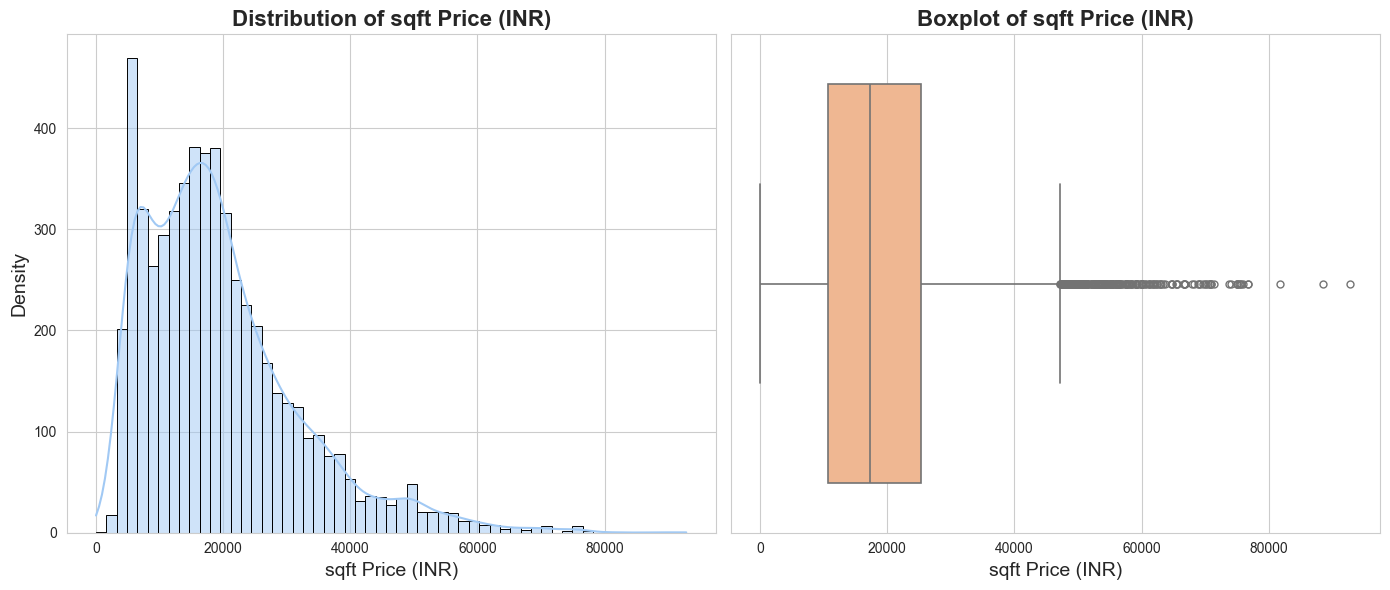

In [47]:
# Distribution and Box plot of sqft Price
plot_distribution_and_boxplot(df, 'sqft Price (INR)')

In [48]:
df['sqft Price (INR)'].describe()

count     5687.000000
mean     19661.426999
std      12385.517335
min         35.000000
25%      10634.500000
50%      17304.000000
75%      25245.500000
max      92857.000000
Name: sqft Price (INR), dtype: float64

In [49]:
# Property listings that have unusually very low sqft Price
df[df['sqft Price (INR)'] < 1000]

,Possession Status,Availability Starts From,Floor No,Commercial,Developer,Price (Crores),Landmark,Covered Area,Society,sqft Price (INR),Carpet Area,Area,Unit of Carpet Area,Furnished Type,Bathrooms,Facing,Transaction Type,Type of Property,City,Bedrooms,Posted By,Total Floors,isPrimeLocationProperty,Unit of Covered Area,Property Lifespan,Balconies,Power Back Up,Lift,Rain Water Harvesting,Club House,Swimming Pool,Gymnasium,Park,Parking,Security,Water Storage,Private Terrace/Garden,Vaastu Compliant,Service/Goods Lift,Air Conditioned,Visitor Parking,Intercom Facility,Maintenance Staff,Waste Disposal,Laundry Service,Internet/Wi-Fi Connectivity,DTH Television Facility,RO Water System,Banquet Hall,Bar/Lounge,Cafeteria/Food Court,Conference Room,Piped Gas,Jogging and Strolling Track,Outdoor Tennis Courts,Mansion,Downtown,Skyline View,Wrap Around Balcony,Island Kitchen Layout,Full Glass Wall,House help accommodation,Concierge Services,Garden View,Marble flooring,Well Furnished,Modular Kitchen,Helipad,Private pool,Private Jaccuzi,Mini Cinema Theatre,Golf Course,Infinity Swimming Pool,Pool with temperature control,Sea facing,Skydeck,Earth quake resistant,Theme based Architectures,Health club with Steam / Jaccuzi,Large Clubhouse,Large Open space,Fingerprint Access,Grand Entrance lobby,Private Garage,Fireplace,Wine Cellar,Sky Villa,Water Front,Hilltop,Smart Home,Barbeque space,Kids play area,Library,Puja Room,Study,Servant Room,Store,Aerobics Room,Canopy Walk,Coffee Lounge & Restaurants,Dance Studio,Event Space & Amphitheatre,Flower Gardens,Guest Accommodation,Indoor Squash & Badminton Courts,Kids Play Area,Kids Play Pool With Water Slides,Library And Business Centre,Meditation Area,Multipurpose Courts,Recreational Pool,Rentable CommuniPfty Space,Retail Boulevard (Retail Shops),Cycling & Jogging Track,Fire Fighting Equipment,Aesthetically designed landscape garden,latitude,longitude,geocoded_address,Area_Broader
950,Ready to Move,Immediately,5.0,N,Sadguru Group Housing & Infrastructure,0.25,NaN,NaN,Sadguru Heights I,35.0,530.0,Dahisar East,NaN,Unfurnished,1.0,NaN,Resale,Apartment,Mumbai,1,Owner,6.0,N,NaN,New construction,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19.248693,72.864059,"Dahisar East, R/N Ward, Zone 4, Mumbai Suburba...",Dahisar East


In [50]:
# Fix the data error

# Impute Covered area
df.loc[950, 'Covered Area'] = df.loc[950, 'Carpet Area'] * covered_to_carpet_ratio

# Update sqft price
df.loc[950, 'sqft Price (INR)'] = (df.loc[950, 'Price (Crores)'] * 10000000) / df.loc[950, 'Covered Area']


In [52]:
# Inaccurate sqft Price entries where 'sqft Price' is not matching with Price/Covered_area value

# Get Index
idx = df[(abs((df['Price (Crores)'] * 10000000 / df['Covered Area']).round() - df['sqft Price (INR)']) > 1)].index

# Update sqft Price values for these listings
df.loc[idx, 'sqft Price (INR)'] = (df.loc[idx, 'Price (Crores)'] * 10000000) / df.loc[idx, 'Covered Area']

In [53]:
# Save the dataframe in CSV format
df.to_csv('Output Files\\stage_3_property_data.csv', index=False)